In [1]:
# Data taken from
# pathMA = pathlib.Path("../experiments/0830/MA-30000-sexual-64.yml")
# pathAP = pathlib.Path("../experiments/0830/AP-30000-sexual-62.yml")

In [13]:
import yaml
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
def read_yml(yml_path):
    with open(yml_path, "rb") as file_:
        return yaml.safe_load(file_)
    return pd.DataFrame(yml["PHENOMAP_SPECS"])

In [22]:
def fuse(yml, geno, theory):
    return (
        pd.DataFrame(yml["PHENOMAP_SPECS"])
        .astype({3: int, 4: float})
        .rename({0: "bittype", 1: "bitpos"}, axis=1)
        .query("bittype == 'neut'")
        .pipe(
            # add timing of the negative effect
            lambda df: df.iloc[::2].merge(df.iloc[1::2, [1, 3]], on="bitpos")
            if theory == "AP"
            else df.rename({3: "3_y"}, axis=1)
        )
        .pipe(
            # concat itself because the genomes are diploid
            lambda df: pd.concat([df, df])
        )
        .assign(g=list(geno.iloc[100:2600]) + list(geno.iloc[2700:]))
        .reset_index(drop=True)
    )

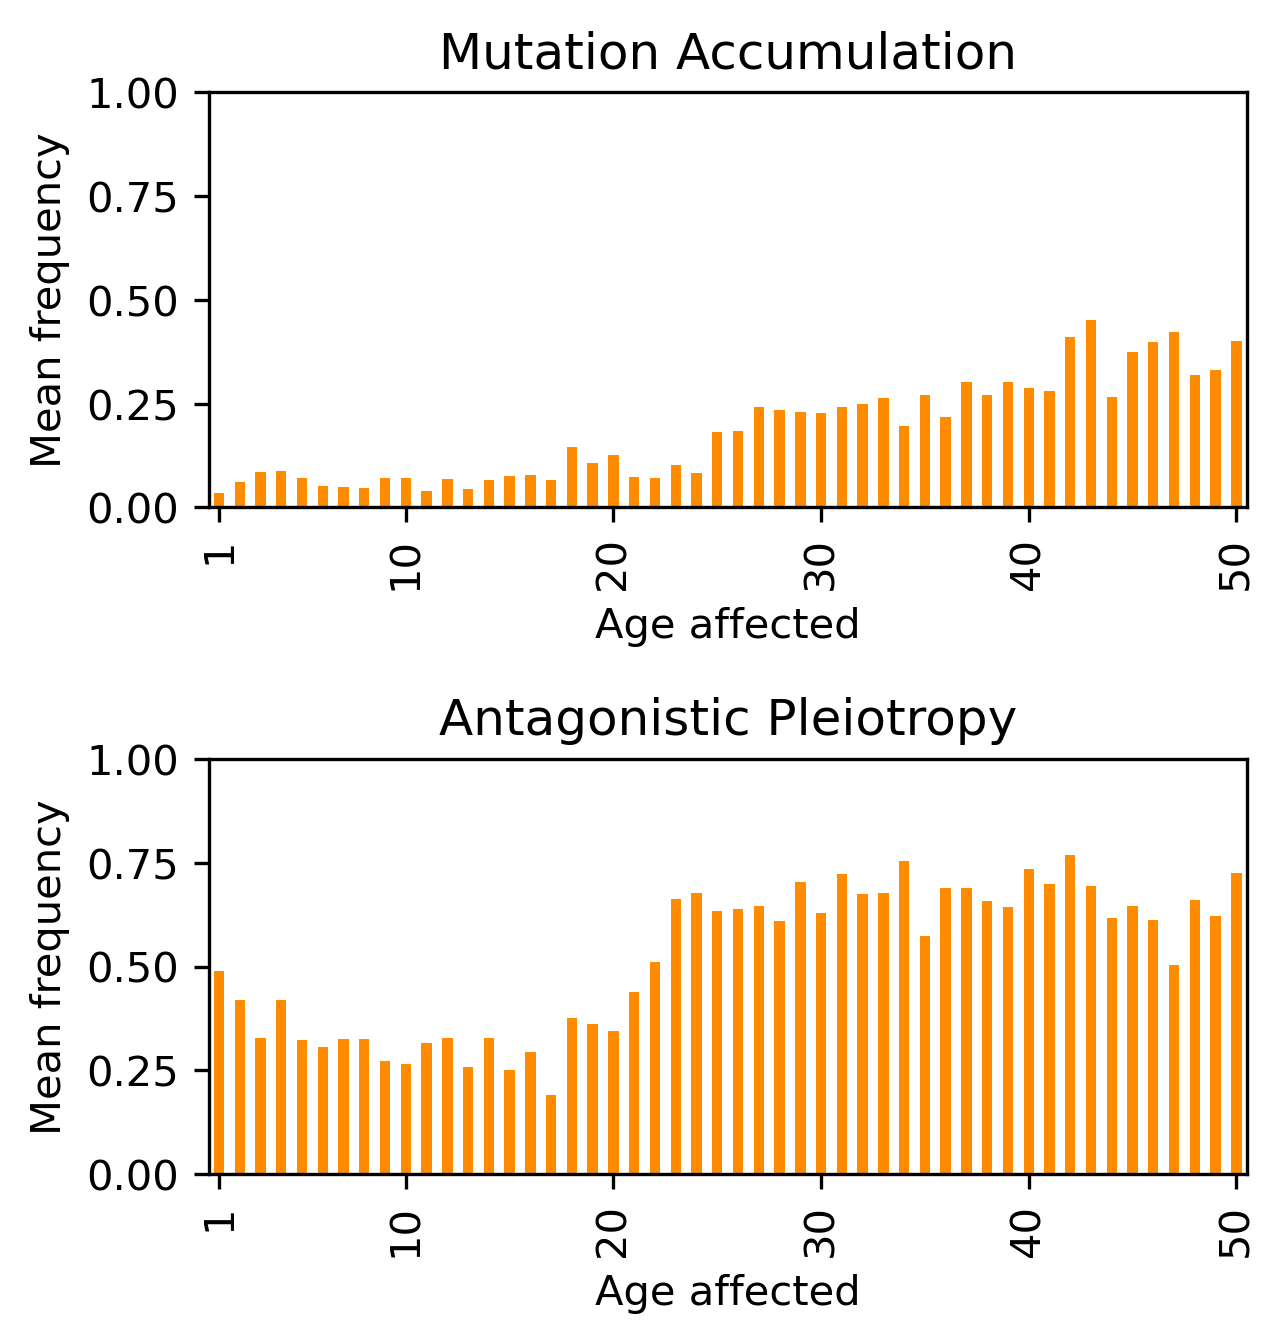

In [28]:
fig, axs = plt.subplots(nrows=2, figsize=(5, 5), dpi=300)
fig.tight_layout(pad=4)

for theory, ax in zip(["MA", "AP"], axs):
    path_yml = f"assets/supp1-phenomap_{theory}.yml"
    path_geno = f"assets/supp1-genotypes_{theory}.csv"

    yml = read_yml(path_yml)
    geno = pd.read_csv(path_geno).iloc[-1]

    # mean frequency of variants that decrease survival rate at age of 3_x
    (
        fuse(yml, geno, theory)
        .groupby("3_y")
        .mean()
        .g.plot.bar(
            ylim=(0, 1),
            ax=ax,
            xlabel="Age affected",
            ylabel="Mean frequency",
            legend=False,
            color="darkorange",
            title="Mutation Accumulation"
            if theory == "MA"
            else "Antagonistic Pleiotropy",
        )
    )
    ax.set(xticks=[0, 9, 19, 29, 39, 49])
plt.show()

# Miscellaneous

In [440]:
path_ = path.with_suffix("") / "0/visor/genotypes.csv"
geno_all = pd.read_csv(path_)
geno = geno_all.iloc[-1]

<AxesSubplot:>

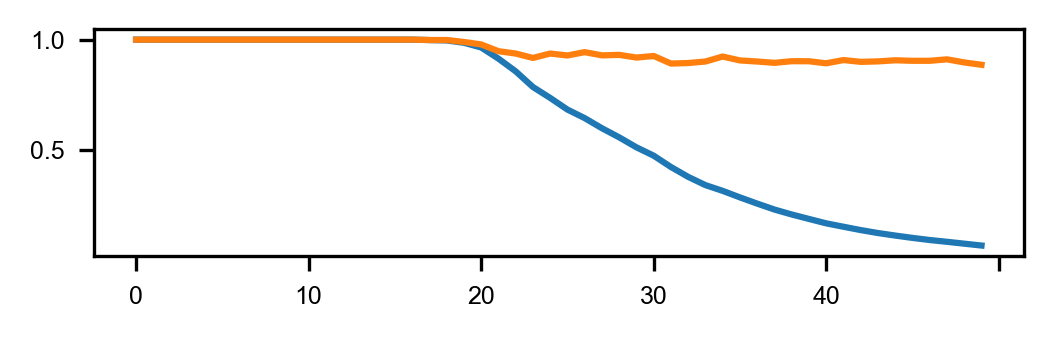

In [441]:
path_ = path.with_suffix("") / "0/visor/phenotypes.csv"
pheno = pd.read_csv(path_).iloc[-1]

pheno.iloc[:50].cumprod().plot()
pheno.iloc[:50].plot()

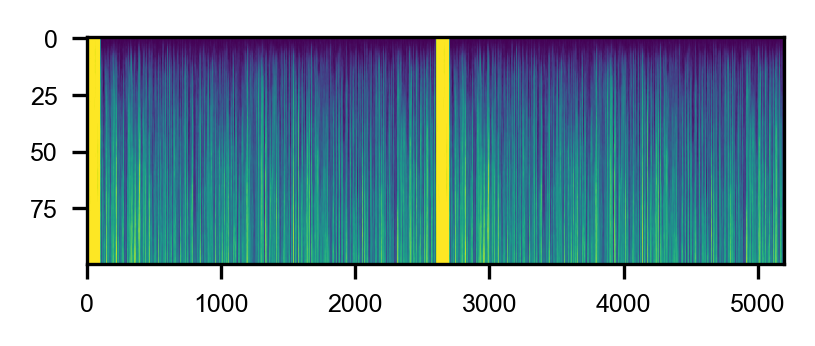

In [442]:
plt.figure(figsize=(3, 1), dpi=300)
plt.imshow(geno_all, aspect="auto")

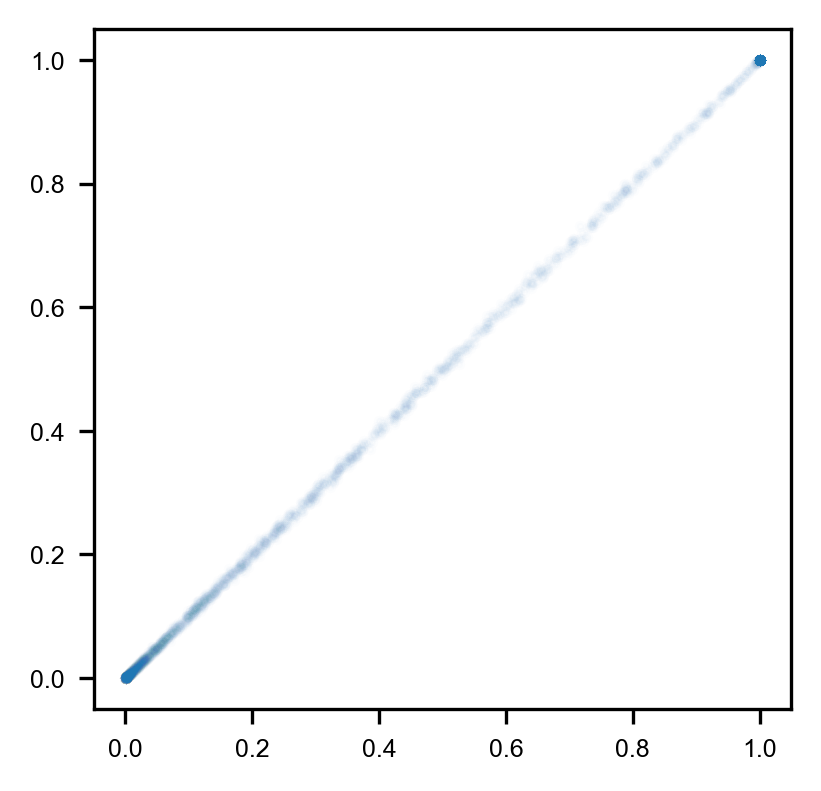

In [443]:
# frequency of one copy vs frequency of another copy of the same genomic bit
plt.figure(figsize=(3, 3), dpi=300)
plt.scatter(
    geno.iloc[100:2600].to_numpy(), geno.iloc[2700:].to_numpy(), s=3, alpha=0.01
)

In [444]:
theory = "MA" if "MA" in str(path) else "AP"
print(theory)

# fixation_threshold = 0.95
fused = (
    pd.DataFrame(yml["PHENOMAP_SPECS"])
    .astype({3: int, 4: float})
    .rename({0: "bittype", 1: "bitpos"}, axis=1)
    .query("bittype == 'neut'")
    .pipe(
        # add timing of the negative effect
        lambda df: df.iloc[::2].merge(df.iloc[1::2, [1, 3]], on="bitpos")
        if theory == "AP"
        else df.rename({3: "3_x"}, axis=1)
    )
    .pipe(
        # concat itself because the genomes are diploid
        lambda df: pd.concat([df, df])
    )
    .assign(g=list(geno.iloc[100:2600]) + list(geno.iloc[2700:]))
    .reset_index(drop=True)
)
fused

AP


,bittype,bitpos,2,3_x,4,3_y,g
0,neut,1,surv,15,0.003500,35,1.000000
1,neut,2,surv,8,0.002131,15,0.288900
2,neut,3,surv,2,0.000406,47,0.289000
3,neut,4,surv,7,0.000058,10,0.001201
4,neut,5,surv,18,0.002187,42,1.000000
...,...,...,...,...,...,...,...
4995,neut,2496,surv,12,0.000012,18,1.000000
4996,neut,2497,surv,15,0.001803,26,0.694100
4997,neut,2498,surv,27,0.002032,48,0.001663
4998,neut,2499,surv,11,0.001022,16,0.051160


(0.0, 1.0)

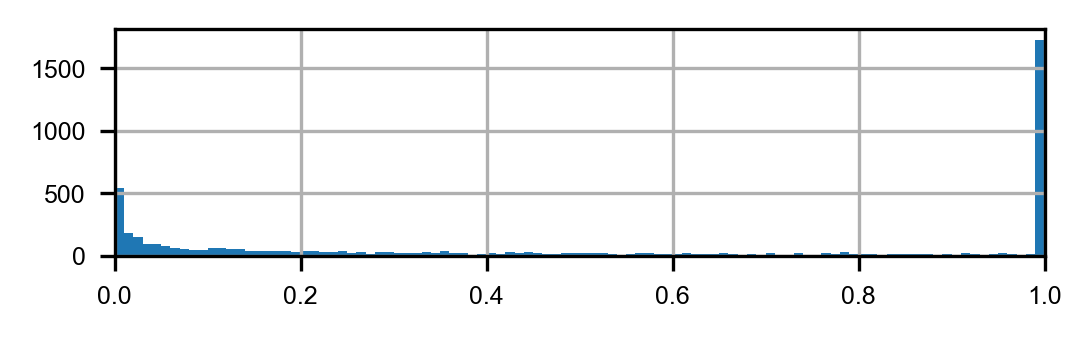

In [445]:
# y number of variants of prevalence x
fused.g.hist(bins=100)
plt.xlim(0, 1)

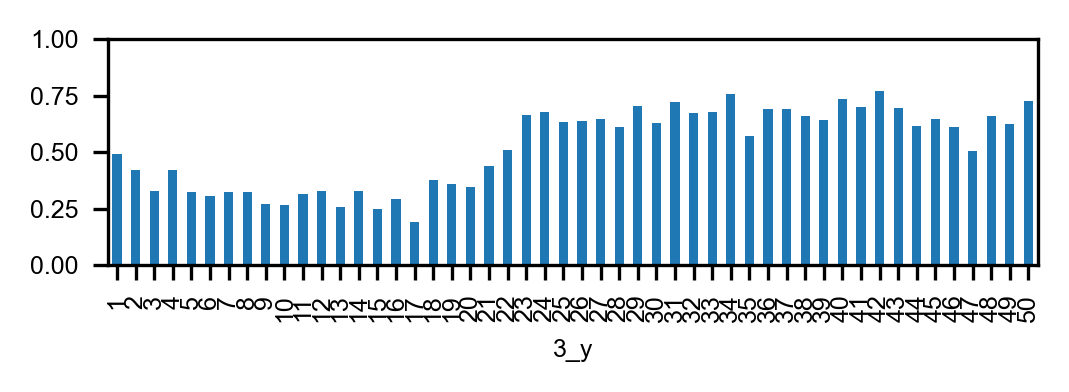

In [451]:
# mean frequency of variants that decrease survival rate at age of 3_x
fused.groupby("3_y").mean().g.plot.bar(ylim=(0, 1))
plt.show()

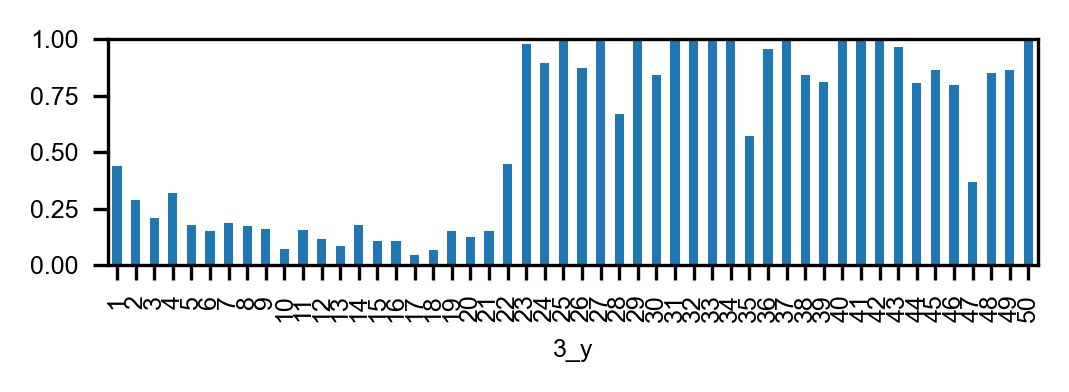

In [450]:
# median frequency of variants that decrease survival rate at age of 3_x
fused.groupby("3_y").median().g.plot.bar(ylim=(0, 1))
plt.show()

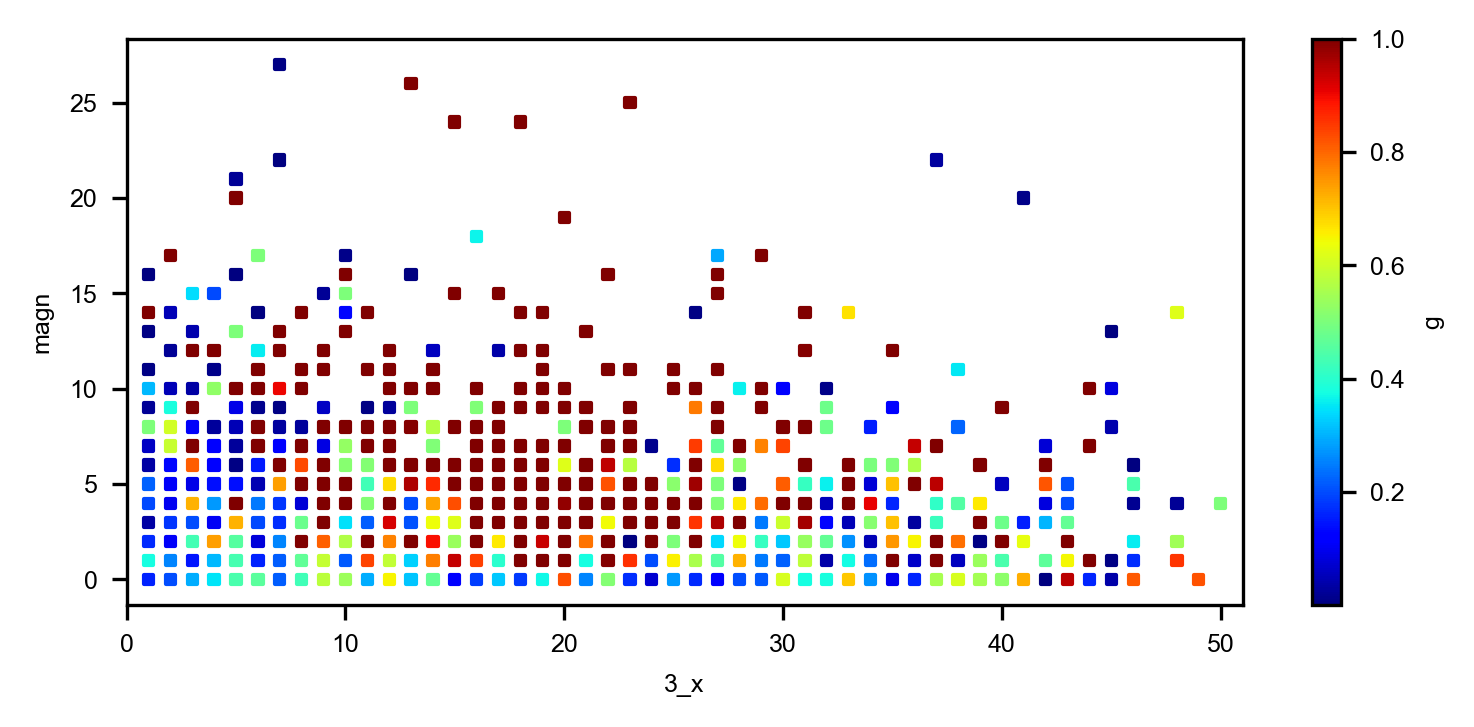

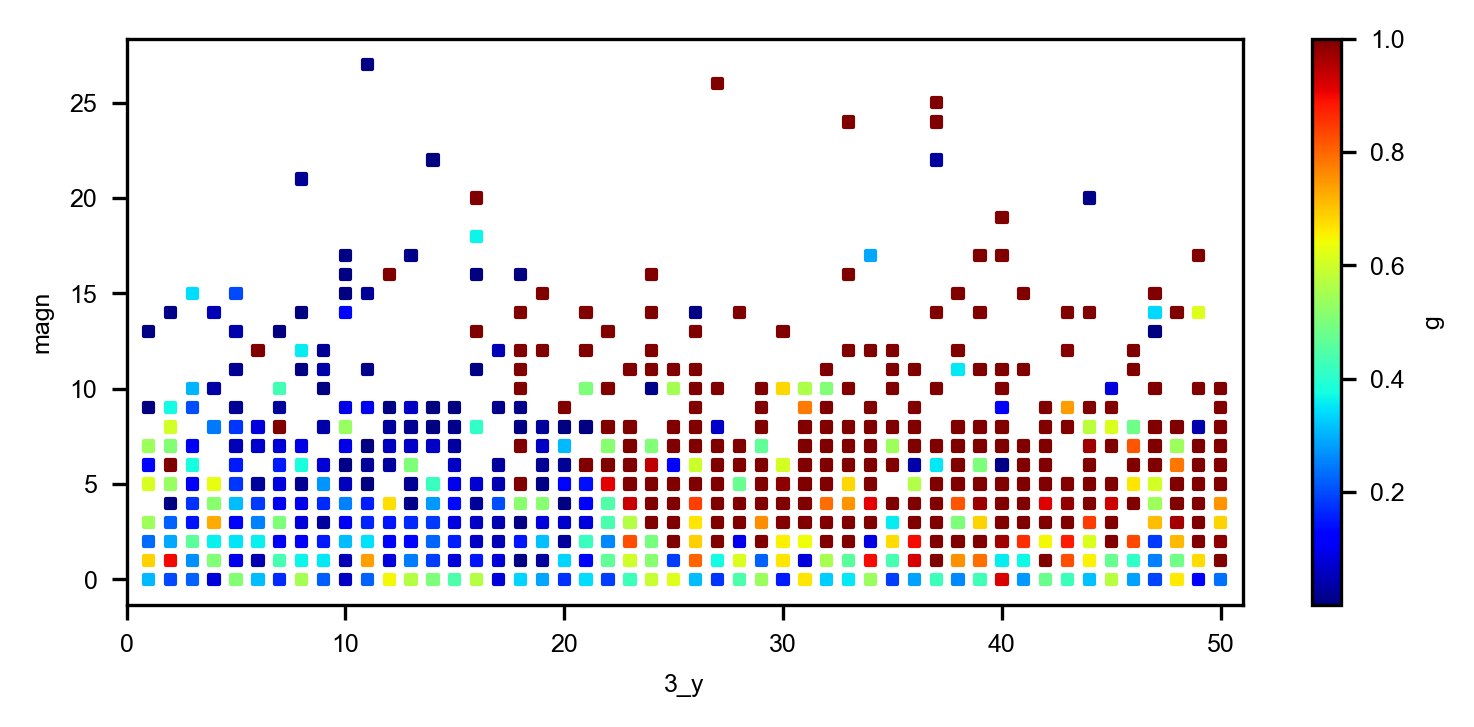

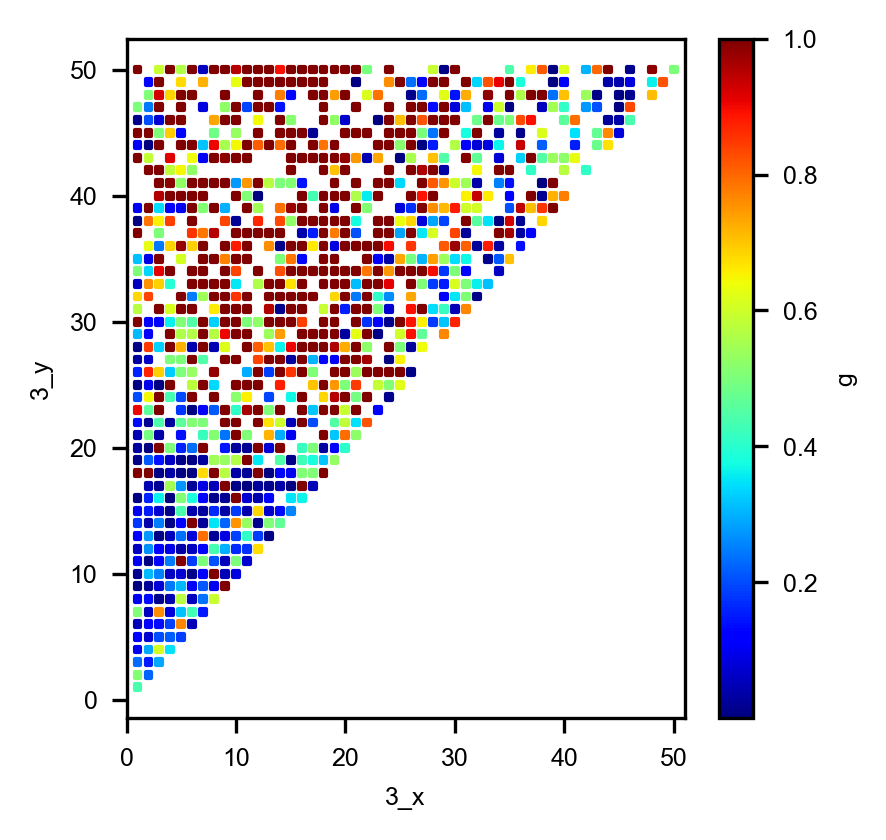

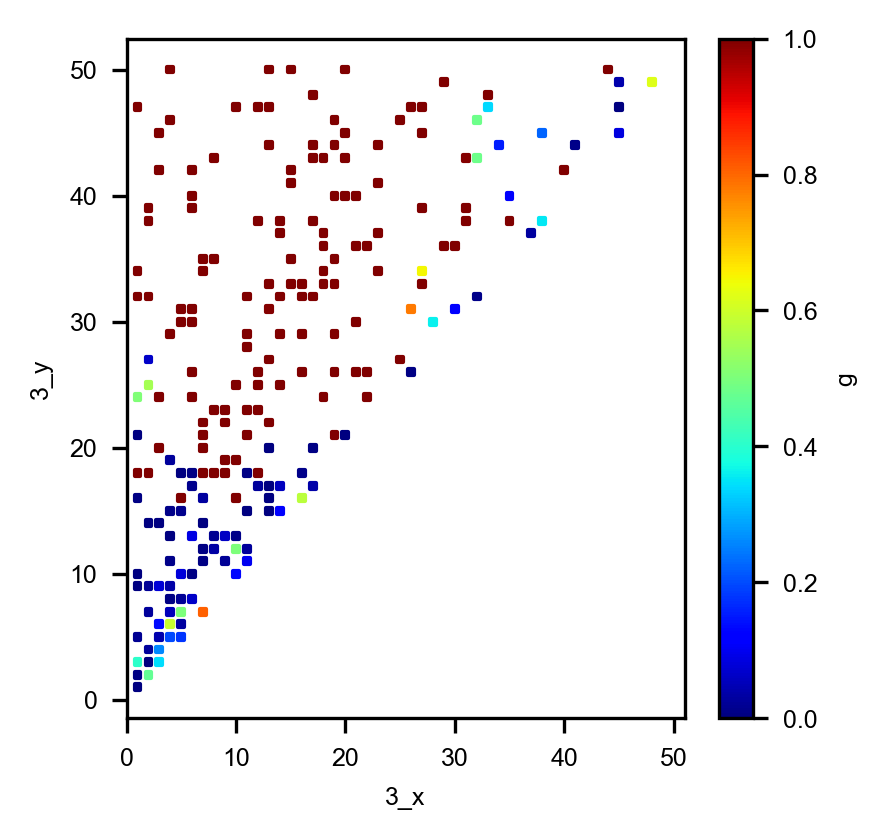

In [449]:
# mean frequency of variants of magnitude y and timing of action x

magn_bin = -0.0003 if theory == "MA" else 0.0004


def plot2d(
    x="3_x", y="magn", figsize=(6, 2.5), s=5, magn_min=-np.inf, magn_max=np.inf, ax=None
):
    if ax is None:
        fig, ax = plt.subplots()
    (
        fused.assign(magn=fused[4] // magn_bin)
        .pipe(lambda df: df[(df.magn < magn_max) & (df.magn >= magn_min)])
        .groupby([x, y])
        .g.median()
        .reset_index()
        .plot.scatter(
            x=x,
            y=y,
            c="g",
            cmap="jet",
            s=s,
            vmax=1,
            # ylim=(-1, 20),
            marker="s",
            figsize=figsize,
            # xlim=(0, 51),
            ax=ax,
            # colorbar=False,
            xlim=(0, 51),
        )
    )
    # plt.show()


plot2d()
plot2d(x="3_y")
plot2d(x="3_x", y="3_y", figsize=(3, 3), s=2)
plot2d(x="3_x", y="3_y", figsize=(3, 3), s=2, magn_min=8)

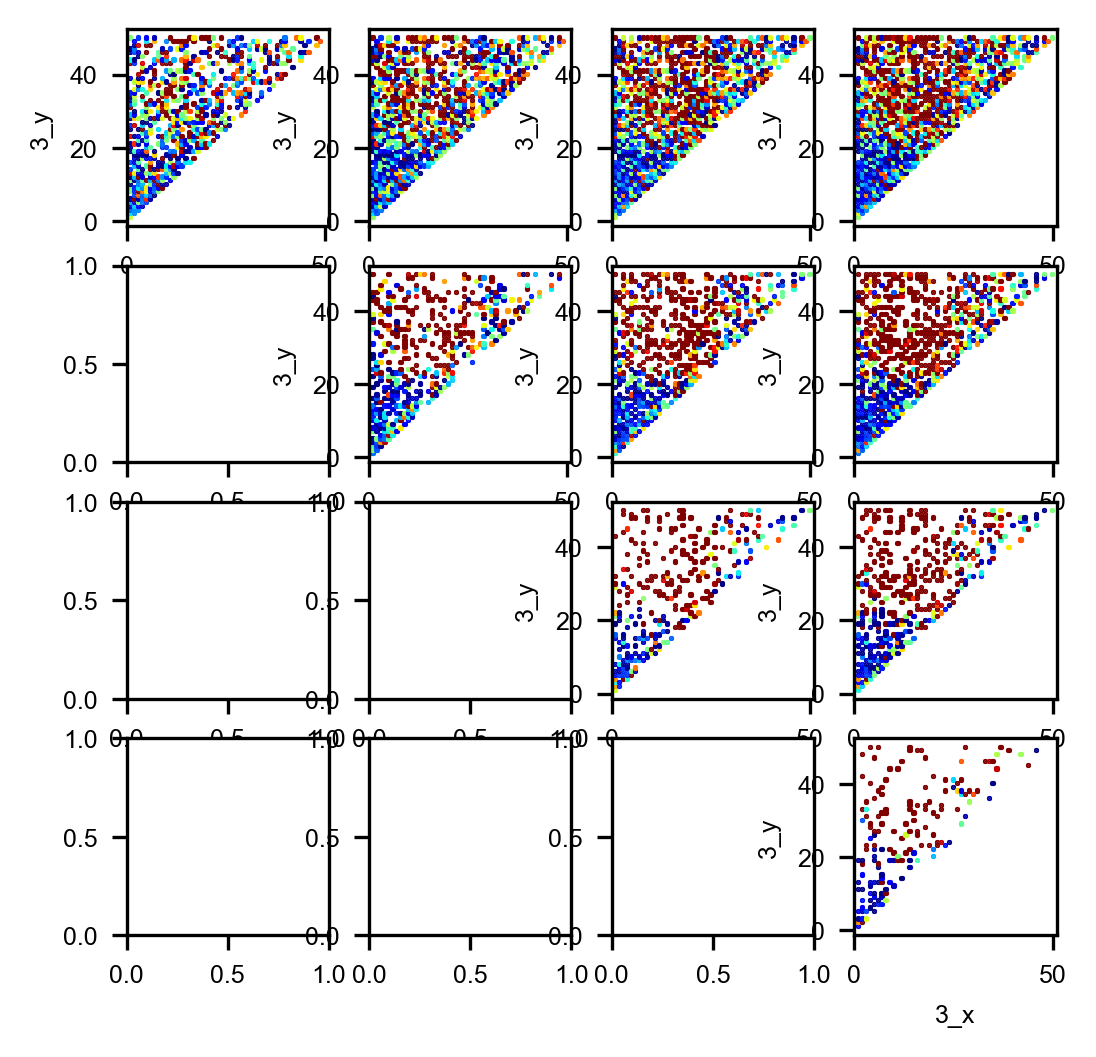

In [421]:
fig, axes = plt.subplots(nrows=4, ncols=4)
axs = axes.flatten()

for mmin in range(0, 10, 2):
    for mmax in range(0, 10, 2):
        if mmax <= mmin:
            continue
        plot2d(
            x="3_x",
            y="3_y",
            s=0.1,
            magn_min=mmin,
            magn_max=mmax,
            figsize=(4, 4),
            ax=axs[mmin // 2 * 4 + mmax // 2 - 1],
        )

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


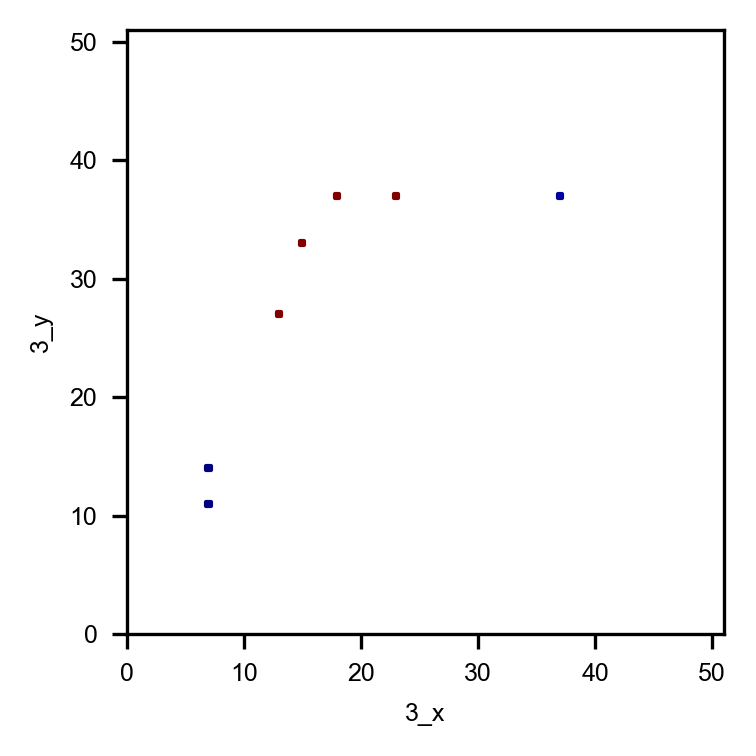

In [388]:
from matplotlib import animation

writer = animation.writers["ffmpeg"](fps=10)
figsize = (3, 3)
fig, ax = plt.subplots(figsize=figsize)


def animate(t):
    print(t)
    plt.cla()
    plot2d(x="3_x", y="3_y", figsize=(2.5, 2.5), s=1, magn_min=t, ax=ax)
    plt.ylim(0, 51)
    fig.tight_layout()


anim = animation.FuncAnimation(fig, animate, frames=10)
anim.save(
    f"temp/anim.gif",
    dpi=300,
    writer=animation.PillowWriter(bitrate=300),
)

In [ ]:
fused.groupby()

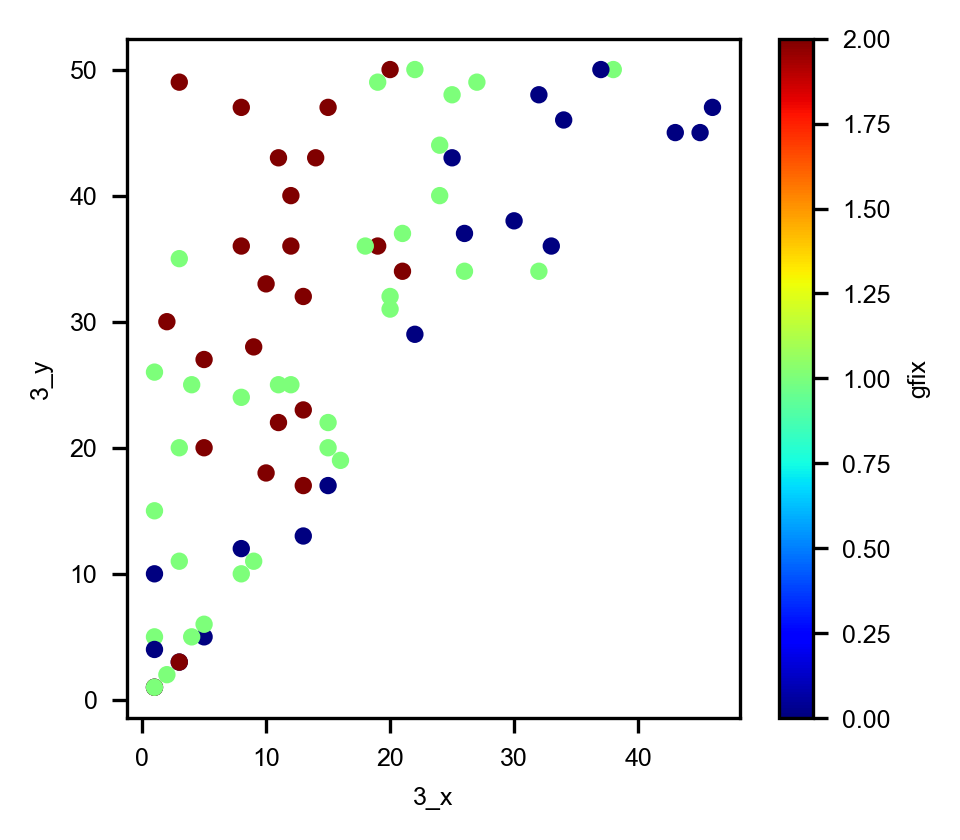

In [126]:
fig, ax = plt.subplots(figsize=(3.3, 3), dpi=300)
fused[fused[4] > 0.005].plot.scatter(
    x="3_x", y="3_y", c="gfix", cmap="jet", ax=ax, s=10
)
ax.set_xlabel("3_x")
plt.show()

In [91]:
# fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
# fused.groupby(["3_x"])["gfix"].mean().plot.bar(ax=ax)

<AxesSubplot:xlabel='3_x', ylabel='3_y'>

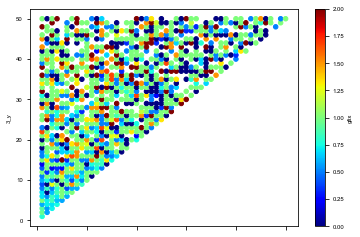

In [85]:
fused.groupby(["3_x", "3_y"])["gfix"].mean().reset_index().plot.scatter(
    x="3_x",
    y="3_y",
    c="gfix",
    cmap="jet",
)

<AxesSubplot:>

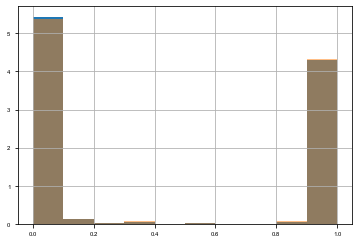

In [70]:
fused[fused.g1 < 0.5].g2.hist(density=True)
fused[fused.g1 > 0.5].g2.hist(density=True, alpha=0.5)

<AxesSubplot:>

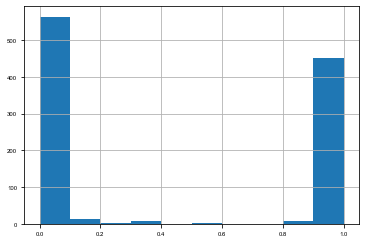

<AxesSubplot:>

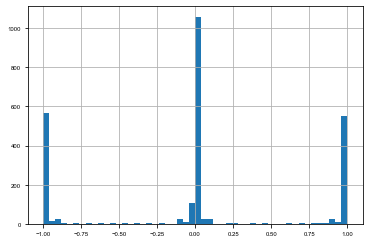

In [56]:
(fused.g1 - fused.g2).hist(bins=50)

In [186]:
geno = pd.read_csv(yml_paths[0].with_suffix("") / "0/visor/genotypes.csv")

In [226]:
geno.drop([str(_) for _ in range(3)], axis=1).drop([str(_) for _ in range(3)], axis=1)

,3,4,5,6,7,8,9,10,11,12,...,5190,5191,5192,5193,5194,5195,5196,5197,5198,5199
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.009719,0.000000,0.01805,0.000000,0.004859,0.00000,0.000694,0.001041,0.000000,0.000000
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.00000,0.041480,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.01028,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.06595,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,0.000000,0.00000,0.007545,1.000000,0.00000,0.222200,0.000000,0.003772,0.000000
96,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,0.000000,0.00000,0.000000,1.000000,0.00000,0.165300,0.000000,0.000000,0.000000
97,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,0.000000,0.00000,0.013440,1.000000,0.01277,0.022850,0.000000,0.005376,0.000000
98,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,0.000000,0.00000,0.000000,1.000000,0.00000,0.000000,0.119000,0.000000,0.008204


In [221]:
geno.drop(range(100), axis=1).drop(range(2500, 2600), axis=1)

KeyError: '[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] not found in axis'

In [181]:
pd.DataFrame(yml["PHENOMAP_SPECS"]).iloc[:-50]

,0,1,2,3,4
0,neut,1,surv,29,0.00038974616994342647
1,neut,1,surv,48,-0.00038974616994342647
2,neut,2,surv,13,0.00164147776206937
3,neut,2,surv,21,-0.00164147776206937
4,neut,3,surv,20,0.006437705073574178
...,...,...,...,...,...
4995,neut,2498,surv,26,-0.0043006289698364715
4996,neut,2499,surv,22,0.0023316574243917
4997,neut,2499,surv,47,-0.0023316574243917
4998,neut,2500,surv,22,0.005274534814686645


In [123]:
genos = pd.DataFrame(GENOS).T.sort_index().droplevel(3, axis=0)

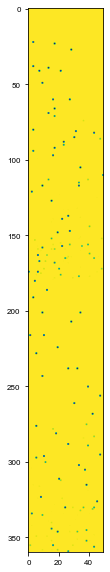

In [126]:
# plt.figure(figsize=(10, 10))
plt.imshow(genos)

# Other

## Plot survivorship

In [198]:
# ax_set_styles_surv = dict(
#     ylim=[0, 1.01],
#     # yticks=[0, 0.05, 0.1],
#     # yticklabels=[0, 0.05, 0.1],
# )


# def plot_surv(df, repr_mode, ax, lw):

#     # plot lines
#     default_survivorship = 0.95 ** np.arange(51)
#     ax.plot(default_survivorship, color="gray", ls="dotted", lw=lw)
#     ax.vlines(10, 0, 1, color="magenta", ls="dotted", alpha=0.5, lw=lw)

#     # calculate data to plot
#     a = df.cumprod(1).loc[aging_theory, :, repr_mode].copy()
#     a.insert(0, "newcol", [1] * len(a), allow_duplicates=True)
#     a = a.T.reset_index(drop=True).T

#     # plot background curves
#     a.T.plot(
#         legend=False,
#         color=plot_colors,
#         ax=ax,
#         alpha=0.1,
#         lw=lw,
#     )

#     # plot mean curve
#     a.reset_index().groupby("index").mean(0).T.plot(
#         ax=ax,
#         color=colors,
#         lw=lw,
#     )

#     # ax.legend(
#     #     handles=patches,
#     #     frameon=False,
#     #     # prop={"size": 4},
#     #     loc=[0.7, 0.015],
#     # )

#     ax.set(**ax_set_styles_general, **ax_set_styles_surv)
#     ax.spines[["right", "top"]].set_visible(False)
#     ax.get_legend().remove()


# for aging_theory in aging_theories:
#     fig, ax = plt.subplots(figsize=figsize)

#     # main plot
#     plot_surv(df, "sexual", ax, lw=0.5)

#     # inset
#     ax = fig.add_axes([0.68, 0.66, 0.2, 0.2])
#     plot_surv(df, "asexual_diploid", ax, lw=0.3)

#     fig.savefig(
#         plots_dir / f"2-surv-{aging_theory}.{format_}",
#         bbox_inches="tight",
#         **savefig_settings,
#     )

In [22]:
# RESULTSx = {}

# for i, yml_path in tqdm.tqdm(enumerate(yml_paths), total=len(yml_paths)):

#     # Path to .csv file with phenotypes
#     path = yml_path.with_suffix("") / "0/visor/phenotypes.csv"
#     phenokind, popsize, reprmode, i = yml_path.stem.split("-")

#     # # Read configuration
#     # with open(yml_path, "r") as file_:
#     #     config = yaml.safe_load(file_)
#     # popsize = config["MAX_POPULATION_SIZE"]
#     # reprmode = config["REPRODUCTION_MODE"]

#     # Read in the intrinsic survival rates
#     pheno = pd.read_csv(path, usecols=range(50))

#     if len(pheno) < 50:
#         print([phenokind, popsize, reprmode])
#         continue

#     # Only look at the last evolved rates
#     pheno = pheno.iloc[50]

#     # Save RESULTS
#     RESULTSx[(phenokind, popsize, reprmode, i)] = pheno

In [53]:
aging_theories = ["pos"]

<AxesSubplot:>

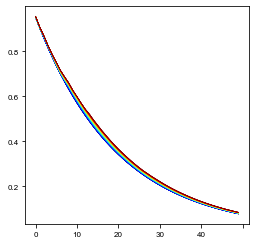

In [116]:
# cont = Container("../experiments/1114/pos-30000-asexual_diploid-101")
cont = Container("../experiments/1114/pos-30000-sexual-158")
# cont = Container("../experiments/1114/pos-3000-sexual-19")
# cont = Container("../experiments/1114/pos-300-sexual-78")
cont.get_df("phenotypes").iloc[:, :50].cumprod(1).T.plot(
    cmap="jet",
    figsize=(4, 4),
    legend=False,
    lw=0.5,
)

<AxesSubplot:>

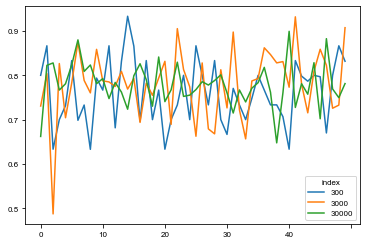

In [82]:
df = pd.DataFrame(RESULTS).T.sort_index().droplevel([0, 3], axis=0)
df.xs("sexual", axis=0, level=1).reset_index().groupby("index").mean().T.plot()

<AxesSubplot:>

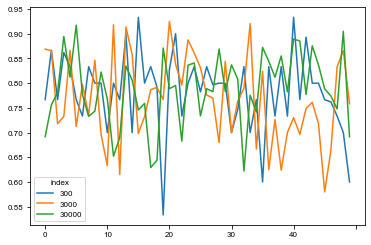

In [84]:
df = pd.DataFrame(RESULTS).T.sort_index().droplevel([0, 3], axis=0)
df.xs("asexual_diploid", axis=0, level=1).reset_index().groupby("index").mean().T.plot()

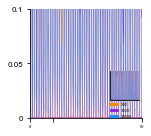

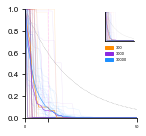

In [54]:
# Transform data into a table

df = pd.DataFrame(RESULTS).T.sort_index().droplevel(3, axis=0)
n_specs_studied = int(len(df) / len(df.index.unique()))

figsize = (2, 2)
dpi = 300

colors = ["darkorange", "blueviolet", "dodgerblue"]
plot_colors = [color for color in colors for _ in range(n_specs_studied)]

patches = [
    # mpatches.Circle(xy=(0, 0), color=colors[0], label="N = 300"),
    # mpatches.Circle(xy=(0, 0), color=colors[1], label="N = 3000"),
    mpatches.Circle(xy=(0, 0), color=colors[0], label="300"),
    mpatches.Circle(xy=(0, 0), color=colors[1], label="3000"),
    mpatches.Circle(xy=(0, 0), color=colors[2], label="30000"),
]

# Plot mortality


for aging_theory in aging_theories:
    fig, ax = plt.subplots(figsize=figsize)
    # plt.hlines(0.05, 0, 51, color="gray", ls="dotted", lw=0.5)
    plt.vlines(10, 0, 1, color="magenta", ls="dotted", alpha=0.5, lw=0.5)
    (
        (1 - df)
        .loc[aging_theory, :, "sexual"]
        .T.plot(
            legend=False,
            color=plot_colors,
            alpha=0.1,
            ax=ax,
            lw=0.5,
        )
    )

    (1 - df.loc[aging_theory, :, "sexual"]).reset_index().groupby("index").mean(
        0
    ).T.plot(
        ax=ax,
        color=colors,
        lw=0.5,
    )
    ax.set_ylim(0, 0.1)
    ax.set_xlim(0, 49)
    ax.set_xticks([0, 10, 49])
    # ax.set_xticklabels([0, "Onset of\nreproduction", 50], fontsize=4)
    ax.set_xticklabels([0, "", 50], fontsize=4)
    ax.set_yticks([0, 0.05, 0.1])
    ax.set_yticklabels([0, 0.05, 0.1])
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    # ax.set_xlabel("Age")
    # ax.set_ylabel("Mortality rate")

    # Legend
    ax.legend(handles=patches, frameon=False, prop={"size": 4}, loc=[0.7, -0.02])

    # Inset
    ax2 = fig.add_axes([0.68, 0.25, 0.2, 0.2])
    # ax2.hlines(0.05, 0, 51, color="gray", ls="dotted", lw=0.2)
    ax2.vlines(10, 0, 1, color="magenta", ls="dotted", alpha=0.5, lw=0.2)

    (
        (1 - df)
        .loc[aging_theory, :, "asexual_diploid"]
        .T.plot(
            legend=False,
            color=plot_colors,
            alpha=0.1,
            ax=ax2,
            lw=0.2,
        )
    )

    (1 - df.loc[aging_theory, :, "asexual_diploid"]).reset_index().groupby(
        "index"
    ).mean(0).T.plot(
        ax=ax2,
        color=colors,
        lw=0.2,
    )
    ax2.set_ylim(0, 0.1)
    ax2.set_xlim(0, 49)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.spines.right.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax2.get_legend().remove()

    # ax2.text(-1, 0.11, "Asexual reproduction", size=3, linespacing=0.9)

    # fig.savefig(plots_dir / f"x2-mort-{aging_theory}.svg", bbox_inches="tight")  # TODO


# Plot Survivorship

default_survivorship = 0.95 ** np.arange(51)

for aging_theory in aging_theories:
    fig, ax = plt.subplots(figsize=figsize)
    ax.vlines(10, 0, 1, color="magenta", ls="dotted", alpha=0.5, lw=0.5)
    ax.plot(default_survivorship, color="gray", ls="dotted", lw=0.5)

    a = df.cumprod(1).loc[aging_theory, :, "sexual"].copy()
    a.insert(0, "newcol", [1] * len(a), allow_duplicates=True)
    a = a.T.reset_index(drop=True).T

    (
        a.T.plot(
            legend=False,
            color=plot_colors,
            ax=ax,
            alpha=0.1,
            lw=0.5,
        )
    )

    a.reset_index().groupby("index").mean(0).T.plot(
        ax=ax,
        color=colors,
        lw=0.5,
    )
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 50)
    ax.set_xticks([0, 10, 50])
    # ax.set_xticklabels([0, "Onset of\nreproduction", 50], fontsize=4)
    ax.set_xticklabels([0, "", 50], fontsize=4)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    # ax.set_xlabel("Age")
    # ax.set_ylabel("Survivorship")

    # Legend
    ax.legend(handles=patches, frameon=False, prop={"size": 4}, loc=[0.7, 0.5])

    # Inset
    ax2 = fig.add_axes([0.68, 0.66, 0.2, 0.2])
    ax2.vlines(10, 0, 1, color="magenta", ls="dotted", alpha=0.5, lw=0.2)
    ax2.plot(default_survivorship, color="gray", ls="dotted", lw=0.2)

    a = df.cumprod(1).loc[aging_theory, :, "asexual_diploid"].copy()
    a.insert(0, "newcol", [1] * len(a), allow_duplicates=True)
    a = a.T.reset_index(drop=True).T

    (
        a.T.plot(
            legend=False,
            color=plot_colors,
            ax=ax2,
            alpha=0.1,
            lw=0.2,
        )
    )

    a.reset_index().groupby("index").mean(0).T.plot(
        ax=ax2,
        color=colors,
        lw=0.2,
    )
    ax2.set_ylim(0, 1)
    ax2.set_xlim(0, 50)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.spines.right.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax2.get_legend().remove()

    # ax2.text(-1, 1.1, "Asexual reproduction", size=3, linespacing=0.9)

    # fig.savefig(plots_dir / f"x2-surv-{aging_theory}.svg", bbox_inches="tight")

# Animate _.yml

In [100]:
dfgeno = pd.read_csv("../temp/_/0/visor/genotypes.csv")

In [101]:
dfanim = pd.read_csv("../temp/_/0/visor/phenotypes.csv")

In [86]:
800 / 32

25.0

In [85]:
xs = np.repeat(range(32), 25)
ys = list(range(25)) * 32

plt.scatter(xs, ys, c=dfgeno.iloc[0], marker="s")

NameError: name 'dfgeno' is not defined

finished


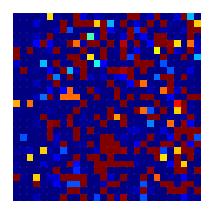

In [139]:
from matplotlib import animation

writer = animation.writers["ffmpeg"](fps=60)
figsize = (3, 3)
fig, ax = plt.subplots(figsize=figsize)


def animate(t):

    plt.cla()
    ax.set(xticks=[], yticks=[])
    data = dfgeno.iloc[t, : 28**2]

    xs = np.repeat(range(28), 28)
    ys = list(range(28)) * 28
    ax.scatter(xs, ys, c=data, marker="s", cmap="jet_r")
    ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
    fig.tight_layout()


import functools

anim = animation.FuncAnimation(fig, animate)
anim.save(
    f"../temp/animate_geno.gif",
    dpi=300,
    writer=animation.PillowWriter(bitrate=300),
)
print("finished")

finished


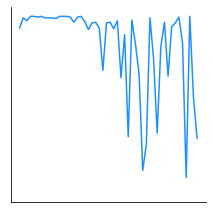

In [142]:
from matplotlib import animation

writer = animation.writers["ffmpeg"](fps=60)
figsize = (3, 3)
fig, ax = plt.subplots(figsize=figsize)


def animate(t):

    plt.cla()
    ax.set(xticks=[], yticks=[], ylim=(0, 1.05))
    data = dfanim.iloc[t, :50]

    ax.plot(data, color="dodgerblue")
    ax.spines[["top", "right"]].set_visible(False)
    fig.tight_layout()


import functools

anim = animation.FuncAnimation(fig, animate)
anim.save(
    f"../temp/animate_pheno.gif",
    dpi=300,
    writer=animation.PillowWriter(bitrate=300),
)
print("finished")

finished


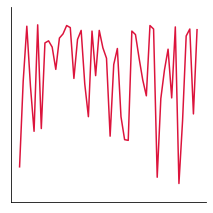

In [141]:
from matplotlib import animation

writer = animation.writers["ffmpeg"](fps=60)
figsize = (3, 3)
fig, ax = plt.subplots(figsize=figsize)


def animate(t):

    plt.cla()
    ax.set(xticks=[], yticks=[], ylim=(0, 0.55))
    data = dfanim.iloc[t, 50:]

    ax.plot(data, color="crimson")
    ax.spines[["top", "right"]].set_visible(False)
    fig.tight_layout()


import functools

anim = animation.FuncAnimation(fig, animate)
anim.save(
    f"../temp/animate_repr.gif",
    dpi=300,
    writer=animation.PillowWriter(bitrate=300),
)
print("finished")

In [ ]:
from matplotlib import animation

writer = animation.writers["ffmpeg"](fps=30)

df = 1 - pd.concat(ANIMRES.values())

figsize = (3, 3)
# dpi = 300

colors = ["crimson", "forestgreen", "dodgerblue"]

patches = [
    mpatches.Circle(xy=(0, 0), color=colors[0], label="N=300"),
    mpatches.Circle(xy=(0, 0), color=colors[1], label="N=3000"),
    mpatches.Circle(xy=(0, 0), color=colors[2], label="N=30000"),
]

fig, ax = plt.subplots(figsize=figsize)

ax_styles = dict(
    xlim=(0, 49),
    xticks=[0, 10, 49],
    xticklabels=([1, "", 50]),
    xlabel="age",
)

ax_styles_mort = dict(
    yticks=[0, 0.05, 0.1],
    yticklabels=[0, 0.05, 0.1],
    ylim=(0, 0.1),
)

ax_styles_surv = dict(
    yticks=[0, 1],
    yticklabels=[0, 1],
    ylim=(0, 1.02),
)


ax.set(**ax_styles)
ax.spines[["top", "right"]].set_visible(False)


def animate(t, aging_theory, data_type):

    plt.cla()
    ax.set(**ax_styles)
    if data_type == "mortality":
        ax.set(**ax_styles_mort)
        ax.hlines(0.05, 0, 51, color="gray", ls="dotted", lw=0.5)
    else:
        ax.set(**ax_styles_surv)
        ax.plot(0.95 ** np.arange(1, 51), color="gray", ls="dotted", lw=0.5)
    ax.set(
        ylabel=data_type,
        title=aging_theory,
        xlabel="age",
    )
    data = (
        df.xs(
            (t, aging_theory, "sexual"),
            level=("t", "phenokind", "reprmode"),
        )
        # .groupby(["popsize"])
        # .mean(0)
    )
    if data_type == "survivorship":
        data = (1 - data).cumprod(1)

    datagr = data.groupby("popsize").mean(0)

    # ax.plot(data.loc["300"].T, color=colors[0], alpha=0.1)
    # ax.plot(data.loc["3000"].T, color=colors[1], alpha=0.1)
    # ax.plot(data.loc["30000"].T, color=colors[2], alpha=0.1)

    ax.plot(datagr.loc["300"], color=colors[0])
    ax.plot(datagr.loc["3000"], color=colors[1])
    ax.plot(datagr.loc["30000"], color=colors[2])
    fig.tight_layout()
    ax.legend(handles=patches, frameon=False, prop={"size": 5.5}, loc=[0.75, 0.2])


import functools

for data_type in ("mortality", "survivorship"):
    print(data_type)
    for aging_theory in ("MA", "AP"):
        print(aging_theory)
        func = functools.partial(
            animate, aging_theory=aging_theory, data_type=data_type
        )
        anim = animation.FuncAnimation(fig, func, interval=100)
        anim.save(
            f"temp/{aging_theory}-{data_type}.gif",
            dpi=300,
            writer=animation.PillowWriter(bitrate=300, fps=10),
        )
print("finished")

# Animations

In [69]:
ANIMRES = {}

for i, yml_path in tqdm.tqdm(enumerate(yml_paths), total=len(yml_paths)):
    path = yml_path.with_suffix("") / "0/visor/phenotypes.csv"
    phenokind, popsize, reprmode, i = yml_path.stem.split("-")
    pheno = pd.read_csv(path, usecols=range(50))
    if len(pheno) < 100:
        print([phenokind, popsize, reprmode])

    multiindex = pd.MultiIndex.from_tuples(
        [(phenokind, popsize, reprmode, i, t) for t in range(len(pheno))],
        names=["phenokind", "popsize", "reprmode", "i", "t"],
    )
    pheno.index = multiindex

    ANIMRES[(phenokind, popsize, reprmode, i)] = pheno

 70%|███████   | 380/540 [00:19<00:07, 22.49it/s]

['pos', '30000', 'sexual']
['pos', '30000', 'sexual']


 71%|███████▏  | 386/540 [00:19<00:07, 21.87it/s]

['pos', '30000', 'sexual']


 73%|███████▎  | 395/540 [00:20<00:06, 21.80it/s]

['pos', '30000', 'sexual']


 74%|███████▍  | 401/540 [00:20<00:06, 21.92it/s]

['pos', '30000', 'sexual']


 76%|███████▋  | 413/540 [00:21<00:05, 21.27it/s]

['pos', '30000', 'sexual']


 78%|███████▊  | 419/540 [00:21<00:05, 23.05it/s]

['pos', '30000', 'sexual']


 79%|███████▉  | 428/540 [00:21<00:04, 23.68it/s]

['pos', '30000', 'sexual']
['pos', '30000', 'sexual']


 82%|████████▏ | 443/540 [00:22<00:04, 21.77it/s]

['pos', '30000', 'sexual']


 83%|████████▎ | 449/540 [00:22<00:04, 21.60it/s]

['pos', '30000', 'sexual']
['pos', '30000', 'sexual']
['pos', '30000', 'sexual']


 85%|████████▍ | 458/540 [00:23<00:03, 22.75it/s]

['pos', '30000', 'sexual']


 87%|████████▋ | 470/540 [00:23<00:03, 19.77it/s]

['pos', '30000', 'sexual']


 88%|████████▊ | 476/540 [00:24<00:02, 21.34it/s]

['pos', '30000', 'sexual']


 91%|█████████▏| 494/540 [00:24<00:02, 22.49it/s]

['pos', '30000', 'sexual']


 95%|█████████▌| 515/540 [00:25<00:01, 22.95it/s]

['pos', '30000', 'sexual']
['pos', '30000', 'sexual']


 98%|█████████▊| 527/540 [00:26<00:00, 22.99it/s]

['pos', '30000', 'sexual']


 99%|█████████▉| 536/540 [00:26<00:00, 24.07it/s]

['pos', '30000', 'sexual']


100%|██████████| 540/540 [00:26<00:00, 20.01it/s]

['pos', '30000', 'sexual']


In [12]:
# pd.concat(ANIMRES.values()).xs(
#     (0, "AP", "sexual"),
#     level=("t", "phenokind", "reprmode"),
# ).groupby(["popsize"]).mean(0).loc["300"]

In [146]:
%matplotlib nbagg

In [147]:
from matplotlib import animation

writer = animation.writers["ffmpeg"](fps=30)

df = 1 - pd.concat(ANIMRES.values())

figsize = (3, 3)
# dpi = 300

colors = ["crimson", "forestgreen", "dodgerblue"]

patches = [
    mpatches.Circle(xy=(0, 0), color=colors[0], label="N=300"),
    mpatches.Circle(xy=(0, 0), color=colors[1], label="N=3000"),
    mpatches.Circle(xy=(0, 0), color=colors[2], label="N=30000"),
]

fig, ax = plt.subplots(figsize=figsize)

ax_styles = dict(
    xlim=(0, 49),
    xticks=[0, 10, 49],
    xticklabels=([1, "", 50]),
    xlabel="age",
)

ax_styles_mort = dict(
    yticks=[0, 0.05, 0.1],
    yticklabels=[0, 0.05, 0.1],
    ylim=(0, 0.1),
)

ax_styles_surv = dict(
    yticks=[0, 1],
    yticklabels=[0, 1],
    ylim=(0, 1.02),
)


ax.set(**ax_styles)
ax.spines[["top", "right"]].set_visible(False)


def animate(t, aging_theory, data_type, reprmode):

    plt.cla()
    ax.set(**ax_styles)
    if data_type == "mortality":
        ax.set(**ax_styles_mort)
        ax.hlines(0.05, 0, 51, color="gray", ls="dotted", lw=0.5)
    else:
        ax.set(**ax_styles_surv)
        ax.plot(0.95 ** np.arange(1, 51), color="gray", ls="dotted", lw=0.5)
    ax.set(
        ylabel=data_type,
        title=aging_theory,
        xlabel="age",
    )
    data = (
        df.xs(
            (t, aging_theory, reprmode),
            level=("t", "phenokind", "reprmode"),
        )
        # .groupby(["popsize"])
        # .mean(0)
    )
    if data_type == "survivorship":
        data = (1 - data).cumprod(1)

    datagr = data.groupby("popsize").mean(0)

    # ax.plot(data.loc["300"].T, color=colors[0], alpha=0.1)
    # ax.plot(data.loc["3000"].T, color=colors[1], alpha=0.1)
    # ax.plot(data.loc["30000"].T, color=colors[2], alpha=0.1)

    ax.plot(datagr.loc["300"], color=colors[0])
    ax.plot(datagr.loc["3000"], color=colors[1])
    ax.plot(datagr.loc["30000"], color=colors[2])
    fig.tight_layout()
    ax.legend(handles=patches, frameon=False, prop={"size": 5.5}, loc=[0.75, 0.2])


import functools

for reprmode in ("asexual_diploid", "sexual"):
    for data_type in ("mortality", "survivorship"):
        print([data_type, reprmode])
        for aging_theory in ("MA", "AP"):
            print(aging_theory)
            func = functools.partial(
                animate,
                aging_theory=aging_theory,
                data_type=data_type,
                reprmode=reprmode,
            )
            anim = animation.FuncAnimation(fig, func, interval=100)
            anim.save(
                f"temp/{aging_theory}-{data_type}-{reprmode}.gif",
                dpi=300,
                writer=animation.PillowWriter(bitrate=300, fps=10),
            )
print("finished")

<IPython.core.display.Javascript object>

['mortality', 'asexual_diploid']
MA
AP
['survivorship', 'asexual_diploid']
MA
AP
['mortality', 'sexual']
MA
AP
['survivorship', 'sexual']
MA
AP
finished


# Generation time

In [126]:
gentimes = []

for i, yml_path in tqdm.tqdm(enumerate(yml_paths), total=len(yml_paths)):

    # Path to .csv file with phenotypes
    path = yml_path.with_suffix("") / "0/snapshots/demography/1000000.feather"
    feather = pd.read_feather(path)
    mean_age = feather.query("ages >= 10").ages.mean()

    gentimes.append(yml_path.stem.split("-") + [mean_age])

100%|██████████| 240/240 [00:02<00:00, 84.77it/s]


In [129]:
df = pd.DataFrame(gentimes)
df.columns = ["maap", "popsize", "reprmode", "id", "meanage"]

In [150]:
# df.groupby(["maap", "popsize", "reprmode"]).media

<AxesSubplot:ylabel='Frequency'>

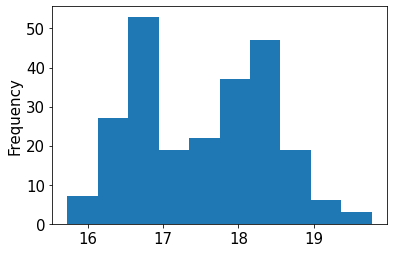

In [159]:
df.meanage.plot.hist()

(array([1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(1, 0, '(AP, 300, asexual_diploid)'),
  Text(2, 0, '(AP, 300, sexual)'),
  Text(3, 0, '(AP, 3000, asexual_diploid)'),
  Text(4, 0, '(AP, 3000, sexual)'),
  Text(5, 0, '(MA, 300, asexual_diploid)'),
  Text(6, 0, '(MA, 300, sexual)'),
  Text(7, 0, '(MA, 3000, asexual_diploid)'),
  Text(8, 0, '(MA, 3000, sexual)')])

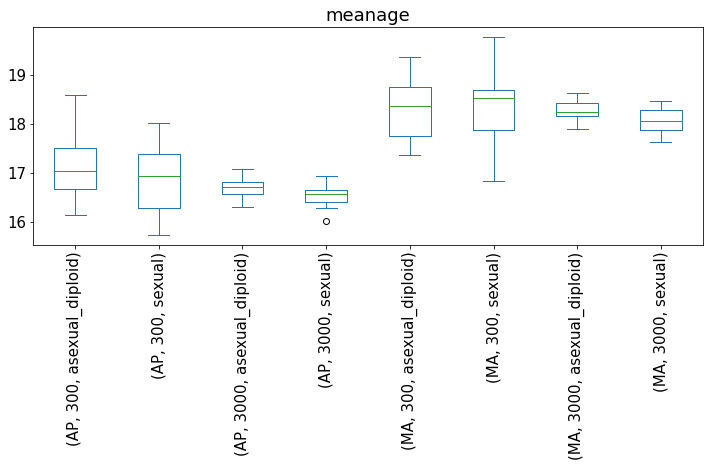

In [156]:
matplotlib.rcParams.update({"font.size": 15})
df.plot.box(by=["maap", "popsize", "reprmode"], figsize=(12, 4))
plt.xticks(rotation=90)

In [162]:
df.meanage.mean(), df.meanage.median()

(17.524274187172992, 17.63188118811881)

# X. Other plots

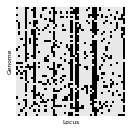

In [22]:
# Random genomes
rng = np.random.default_rng(42)

genomes = np.repeat((rng.random(50) < 0.2).astype(int), 50).reshape(50, 50).T
genomes = np.logical_xor(genomes, rng.random(size=(50, 50)) < 0.15).astype(int)

fig, ax = plt.subplots(figsize=(2, 2))
plt.imshow(genomes, vmin=-0.1, vmax=1, cmap="binary", interpolation="nearest")
ax.set_xlim(-0.5, 50 - 0.5)
ax.set_ylim(-0.5, 50 - 0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("Locus")
ax.set_ylabel("Genome")
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
fig.savefig(plots_dir / "1-genomes.svg", bbox_inches="tight")

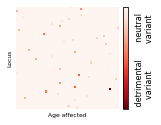

In [89]:
# for MA
phenomap_path = pathlib.Path("../experiments/0815/MA-3000-sexual-1/0/phenomap.csv")
phenomap = pd.read_csv(phenomap_path, header=None)

data = phenomap.iloc[
    100:150, :50
]  # Take first 50 neut loci that encode for the life history traits because of the phenomap
data[data == 0.95] = 0  # Ignore identity effects

# Main plot
fig, ax = plt.subplots(figsize=(2, 2))
im = plt.imshow(
    data,
    cmap="Reds_r",
    vmin=data.min().min(),
    vmax=data.max().max(),
    interpolation="nearest",
)
plt.xlim(-0.5, 49.5)
plt.ylim(-0.5, 49.5)
plt.xticks([])
plt.yticks([])
plt.xlabel("Age affected")
plt.ylabel("Locus")

# Colorbar
cbar = plt.colorbar(im, fraction=0.0455, pad=0.04)
cbar.ax.set_yticklabels([])
cbar.ax.set_yticks([])
cbar.set_label(
    " detrimental       neutral\n    variant           variant",
    rotation=90,
    size=8,
    labelpad=7,
    ha="left",
    y=0,
)

# Despine
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)

# Save
fig.savefig(plots_dir / "1-MA-map.svg", bbox_inches="tight")

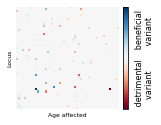

In [88]:
# for AP
phenomap_path = pathlib.Path("../experiments/0815/AP-3000-sexual-5/0/phenomap.csv")
phenomap = pd.read_csv(phenomap_path, header=None)

data = phenomap.iloc[
    100:150, :50
]  # Take first 50 neut loci that encode for the life history traits because of the phenomap
data[data == 0.95] = 0  # Ignore identity effects

# Main plot
fig, ax = plt.subplots(figsize=(2, 2))
im = plt.imshow(
    data,
    cmap="RdBu",
    vmin=data.min().min() * 0.9,
    vmax=data.max().max() * 0.9,
    interpolation="nearest",
)
plt.xlim(-0.5, 49.5)
plt.ylim(-0.5, 49.5)
plt.xticks([])
plt.yticks([])
plt.xlabel("Age affected")
plt.ylabel("Locus")

# Colorbar
cbar = plt.colorbar(im, fraction=0.0455, pad=0.04)
cbar.ax.set_yticklabels([])
cbar.ax.set_yticks([])
# cbar.set_label("detrimental ... beneficial", rotation=90, size=8, labelpad=7)
cbar.set_label(
    " detrimental    beneficial\n    variant          variant",
    rotation=90,
    size=8,
    labelpad=7,
    ha="left",
    y=0,
)

# Despine
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)

# Save
fig.savefig(plots_dir / "1-AP-map.svg", bbox_inches="tight")

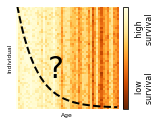

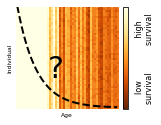

In [126]:
pickle_paths = [
    pathlib.Path("../experiments/0815/MA-3000-sexual-1/0/pickles/1000000"),
    pathlib.Path("../experiments/0815/AP-3000-sexual-5/0/pickles/1000000"),
]

rng = np.random.default_rng(42)

for pickle_path in pickle_paths:

    with open(pickle_path, "rb") as file_:
        pickle_ = pickle.load(file_)

    phenokind = "MA" if "MA" in str(pickle_path) else "AP"

    fig, ax = plt.subplots(figsize=(2, 2))
    phenos = pickle_.phenotypes.copy().reshape(
        pickle_.genomes.shape[0], pickle_.genomes.shape[2]
    )
    phenos[:, 0] = 1

    noise = rng.random(size=[50, 50]) * 0.01
    mask = rng.random(size=noise.shape) < 0.5
    noise[mask] = 0
    phenosplot = (phenos[:50, :50] - noise) ** 1.6

    vmin = 0.8 if phenokind == "AP" else 0.82
    vmax = 0.97 if phenokind == "AP" else 0.92

    im = plt.imshow(
        phenosplot, cmap="YlOrBr_r", vmin=vmin, vmax=vmax, interpolation="nearest"
    )
    plt.xlim(-0.5, 49.5)
    plt.ylim(-0.5, 49.5)
    plt.xticks([])
    plt.yticks([])
    # plt.title("age-dep survival rate")
    plt.xlabel("Age")
    plt.ylabel("Individual")

    # Plot overlay
    plt.plot(50 * 0.9 ** np.arange(50), c="black", alpha=1, lw=2, ls="--")
    ax.text(15, 15, "?", size=30)

    # Colorbar
    cbar = plt.colorbar(im, fraction=0.0455, pad=0.04)
    cbar.ax.set_yticklabels([])
    cbar.ax.set_yticks([])
    # cbar.set_label("low ... high", rotation=90, size=8, labelpad=7)
    cbar.set_label(
        "      low                 high\n  survival           survival",
        rotation=90,
        size=8,
        labelpad=7,
        ha="left",
        y=0,
    )

    # Despine
    ax.spines.right.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)

    fig.savefig(plots_dir / f"1-{phenokind}-pheno.svg", bbox_inches="tight")